# Randomized Incremental Construction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [3]:
def generate_random_points(n_points=50, x_range=(0, 1), y_range=(0, 1), seed=None):
    if seed is not None:
        np.random.seed(seed)

    x = np.random.uniform(x_range[0], x_range[1], n_points)
    y = np.random.uniform(y_range[0], y_range[1], n_points)
    
    points = np.column_stack((x, y))
    return points

def generate_gaussian_points(n_points=50, mean=(0.5, 0.5), cov=None, seed=None):
    """2D Gaussian distributed points."""
    if seed is not None:
        np.random.seed(seed)
    if cov is None:
        cov = [[0.02, 0.0], [0.0, 0.02]]  # isotropic default covariance
    points = np.random.multivariate_normal(mean, cov, n_points)
    return np.clip(points, 0, 1)  # keep in [0,1] range


def generate_poisson_disc_points(radius=0.2, x_range=(0, 1), y_range=(0, 1), k=30, seed=None):
    """
    Poisson disk sampling (Blue noise).
    - radius: minimum distance between points.
    - k: number of candidates per active point.
    """
    if seed is not None:
        np.random.seed(seed)

    width, height = x_range[1] - x_range[0], y_range[1] - y_range[0]
    cell_size = radius / np.sqrt(2)
    grid_w, grid_h = int(np.ceil(width / cell_size)), int(np.ceil(height / cell_size))
    grid = -np.ones((grid_h, grid_w), dtype=int)
    points = []
    active_list = []

    def in_bounds(p):
        return x_range[0] <= p[0] <= x_range[1] and y_range[0] <= p[1] <= y_range[1]

    def grid_coords(p):
        return int((p[0] - x_range[0]) / cell_size), int((p[1] - y_range[0]) / cell_size)

    def too_close(p):
        gx, gy = grid_coords(p)
        for i in range(max(gy - 2, 0), min(gy + 3, grid_h)):
            for j in range(max(gx - 2, 0), min(gx + 3, grid_w)):
                idx = grid[i, j]
                if idx != -1:
                    dist = np.linalg.norm(points[idx] - p)
                    if dist < radius:
                        return True
        return False

    # Initial point
    first_point = np.array([
        np.random.uniform(x_range[0], x_range[1]),
        np.random.uniform(y_range[0], y_range[1])
    ])
    points.append(first_point)
    active_list.append(0)
    gx, gy = grid_coords(first_point)
    grid[gy, gx] = 0

    while active_list:
        idx = np.random.choice(active_list)
        base_point = points[idx]
        found = False
        for _ in range(k):
            theta = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(radius, 2 * radius)
            new_point = base_point + np.array([r * np.cos(theta), r * np.sin(theta)])
            if in_bounds(new_point) and not too_close(new_point):
                points.append(new_point)
                gx, gy = grid_coords(new_point)
                grid[gy, gx] = len(points) - 1
                active_list.append(len(points) - 1)
                found = True
                break
        if not found:
            active_list.remove(idx)
    return np.array(points)


def generate_clustered_points(n_points=100, n_clusters=3, x_range=(0, 1), y_range=(0, 1), seed=None):
    """Multiple dense clusters with sparse regions between them."""
    if seed is not None:
        np.random.seed(seed)
    cluster_centers = np.random.uniform([x_range[0], y_range[0]], [x_range[1], y_range[1]], (n_clusters, 2))
    points_per_cluster = n_points // n_clusters
    remainder = n_points % n_clusters
    points = []
    for i, center in enumerate(cluster_centers):
        size = points_per_cluster + (1 if i < remainder else 0)
        cov = np.diag(np.random.uniform(0.001, 0.01, 2))
        cluster = np.random.multivariate_normal(center, cov, size)
        points.append(cluster)
    return np.clip(np.vstack(points), 0, 1)

##### Implementation Code

In [9]:
from __future__ import print_function
import math

def CalcDist(a, b):
	#Pythagorean theorem
	return ((a[0] - b[0]) ** 2. + (a[1] - b[1]) ** 2.) ** 0.5

def CalcDistCached(pts, a, b, distCache):
	ptIds = (a, b)
	distId = min(ptIds), max(ptIds)
	if distId in distCache:
		return distCache[distId]
	
	dist = CalcDist(pts[a], pts[b])
	distCache[distId] = dist
	return dist

def RadialDistance(pts, seedIndex):
	dists = []
	seedPt = pts[seedIndex]

	for ptNum, pt in enumerate(pts):
		dist = CalcDist(pt, seedPt)
		dists.append((dist, ptNum))

	dists.sort()
	return dists

def FindSmallestCircumCircle(pts, firstIndex, secondIndex):
	
	a = CalcDist(pts[firstIndex], pts[secondIndex])
	if a == 0.:
		raise Exception("Zero distance between duplicate points is not allowed")

	diams = []
	for ptNum, pt in enumerate(pts):
		if ptNum == firstIndex:
			continue
		if ptNum == secondIndex:
			continue
		b = CalcDist(pts[firstIndex], pts[ptNum])
		c = CalcDist(pts[secondIndex], pts[ptNum])

		#https://en.wikipedia.org/wiki/Heron%27s_formula#Numerical_stability
		x1 = (a+(b+c))
		x2 = (c-(a-b))
		x3 = (c+(a-b))
		x4 = (a+(b-c))
		x = x1*x2*x3*x4
		if x > 0.:
			sqrtx = x**0.5
			if sqrtx > 0.:
				diam = 0.5*a*b*c/sqrtx
				diams.append((diam, ptNum))
				#print(ptNum, a, b, c)
			else:
				#Prevent division by zero
				diams.append((float("inf"), ptNum))
		else:
			#Numerical instability detected
			diams.append((float("inf"), ptNum))
	
	diams.sort()
	return diams

def CircumCircleCentre(pta, ptb, ptc):
	#https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates
	pta2 = (pta[0]**2.+pta[1]**2.)
	ptb2 = (ptb[0]**2.+ptb[1]**2.)
	ptc2 = (ptc[0]**2.+ptc[1]**2.)

	d = 2.*(pta[0]*(ptb[1]-ptc[1])+ptb[0]*(ptc[1]-pta[1])+ptc[0]*(pta[1]-ptb[1]))
	if d == 0.:
		raise RuntimeError("Could not find circumcircle centre")

	ux = (pta2*(ptb[1]-ptc[1]) + ptb2*(ptc[1]-pta[1]) + ptc2*(pta[1]-ptb[1])) / d
	uy = (pta2*(ptc[0]-ptb[0]) + ptb2*(pta[0]-ptc[0]) + ptc2*(ptb[0]-pta[0])) / d

	return ux, uy

def RightHandedCheck(pts, pt1, pt2, pt3):
	vec21 = (pts[pt1][0] - pts[pt2][0], pts[pt1][1] - pts[pt2][1])
	vec23 = (pts[pt3][0] - pts[pt2][0], pts[pt3][1] - pts[pt2][1])
	return vec21[0] * vec23[1] - vec21[1] * vec23[0]

def FormTriangles(pts, seedTriangle, orderToAddPts):
	#print(pts)
	#print(seedTriangle)
	#print(orderToAddPts)
	
	triangles = [seedTriangle]
	hull = seedTriangle[:]

	for ptToAdd in orderToAddPts:
		#print("adding point", ptToAdd, pts[ptToAdd])

		#Check which hull faces are visible
		visInd = []
		visList = []
		for hInd in range(len(hull)):
			#print(pts[hull[hInd]], pts[hull[(hInd+1) % len(hull)]])
			vis = RightHandedCheck(pts, hull[hInd], hull[(hInd+1) % len(hull)], ptToAdd)
			#print("vis", hInd, vis)
			visList.append(vis)
			if vis <= 0.:
				visInd.append(hInd)

		if len(visInd) == 0:
			raise Exception("No hull sides visible")

		#Check for range of sides that are visible
		firstSide = 0
		while firstSide in visInd:
			firstSide += 1
			if firstSide >= len(hull):
				raise Exception("No sides are not visible to point")

		while firstSide not in visInd:
			firstSide = (firstSide + 1) % len(hull)
		
		lastSide = firstSide
		while (lastSide+1) % len(hull) in visInd:
			lastSide = (lastSide+1) % len(hull)

		#Get copy of retained section of hull
		cursor = (lastSide + 1) % len(hull)
		newHull = []
		iterating = True
		while iterating:
			newHull.append(hull[cursor])
			if cursor in visInd:
				iterating = False
			cursor = (cursor + 1) % len(hull)

		#Add new point to hull
		newHull.append(ptToAdd)

		#Form new triangles
		cursor = firstSide
		iterating = True
		while iterating:
			tri = (hull[cursor], ptToAdd, hull[(cursor+1)%len(hull)])
			#print("Found triangle", tri)
			triangles.append(tri)

			if cursor == lastSide:
				iterating = False
			cursor = (cursor + 1) % len(hull)

		#print("newhull" , newHull)
		hull = newHull
	return hull, triangles

def CalcTriangleAng(pts, angleCache, pt1, pt2, pt3):

	angId = (pt1, pt2, pt3)
	if angId in angleCache:
		return angleCache[angId]

	#Angle is computed on pt3. pt1 and pt2 define the side opposite the angle
	pt1v = pts[pt1]
	pt2v = pts[pt2]
	pt3v = pts[pt3]
	v31 = (pt1v[0] - pt3v[0], pt1v[1] - pt3v[1])
	v32 = (pt2v[0] - pt3v[0], pt2v[1] - pt3v[1])
	mv31 = (v31[0]**2. + v31[1]**2.) ** 0.5
	mv32 = (v32[0]**2. + v32[1]**2.) ** 0.5
	if mv31 == 0. or mv32 == 0.:
		raise RuntimeError("Angle not defined for zero area triangles")

	v31n = [c / mv31 for c in v31]
	v32n = [c / mv32 for c in v32]
	crossProd = - v31n[0] * v32n[1] + v31n[1] * v32n[0]
	dotProd = v31n[0] * v32n[0] + v31n[1] * v32n[1]
	
	#Limit to valid range
	if dotProd > 1.: dotProd = 1.
	if dotProd < -1.: dotProd = -1.

	#print(crossProd < 0., crossProd)
	#print(math.asin(crossProd), math.acos(dotProd), cosAng)
	if crossProd < 0.:
		#Reflex angle detected
		trigAng = 2. * math.pi - math.acos(dotProd)
	else:
		#Acute or obtuse angle
		trigAng = math.acos(dotProd)

	angleCache[angId] = trigAng
	return trigAng

def CheckAndFlipTrianglePair(pts, triOrdered1, triOrdered2, angleCache, distCache, debugMode = 0):

	if debugMode and RightHandedCheck(pts, *triOrdered1) < 0.:
		raise RuntimeError("Left hand triangle detected", triOrdered1)
	if debugMode and RightHandedCheck(pts, *triOrdered2) < 0.:
		raise RuntimeError("Left hand triangle detected", triOrdered2)
	#print("triOrdered1", triOrdered1)
	#print("triOrdered2", triOrdered2)
	quad = triOrdered1[0], triOrdered1[2], triOrdered2[2], triOrdered2[1]
	#print("quad", quad)

	try:
		t1 = CalcTriangleAng(pts, angleCache, quad[0], quad[2], quad[1])
		t3 = CalcTriangleAng(pts, angleCache, quad[2], quad[0], quad[3])
	except RuntimeError:
		return False, triOrdered1, triOrdered2

	flipDegenerateTri = (t1 == math.pi or t3 == math.pi)
	angTotal = t1 + t3
	flipForDelaunay = angTotal > math.pi

	#print(ang1, ang2, angTotal)
	if flipDegenerateTri or flipForDelaunay:
		#print("Flip possibly required", angTotal, triOrdered1, triOrdered2)
		try:
			t2 = CalcTriangleAng(pts, angleCache, quad[1], quad[3], quad[2])
			t4 = CalcTriangleAng(pts, angleCache, quad[3], quad[1], quad[0])
		except RuntimeError:
			return False, triOrdered1, triOrdered2
		#t1 + t2 + t3 + t4 == 2 * math.pi

		if flipDegenerateTri and (t2 > math.pi or t4 > math.pi):
			#Flipping would create an overlap
			return False, triOrdered1, triOrdered2

		if t2 == math.pi or t4 == math.pi:
			#print(t1, t2, t3, t4)
			#Flipping would create triangle of zero size
			return False, triOrdered1, triOrdered2

		flipTri1 = (triOrdered2[1], triOrdered1[2], triOrdered1[0])
		flipTri2 = (triOrdered1[2], triOrdered2[1], triOrdered1[1])
		#print(flipTri1, flipTri2)
		flipAngTotal = t2 + t4
		#print("Angle when flipped", flipAngTotal)
				
		if flipForDelaunay and flipAngTotal >= angTotal:
			#print("Abort flip", flipAngTotal)
			#No improvement when flipped, so abort flip
			return False, triOrdered1, triOrdered2

		#print(flipTri1, RightHandedCheck(pts, *flipTri1))
		#print(flipTri2, RightHandedCheck(pts, *flipTri2))

		rhCheck1, rhCheck2 = 0., 0.
		if debugMode:
			rhCheck1 = RightHandedCheck(pts, *flipTri1)
			rhCheck2 = RightHandedCheck(pts, *flipTri2)

		#Ensure they are right handed
		if rhCheck1 < 0.:
			raise RuntimeError("Left hand triangle detected", flipTri1)
		if rhCheck2 < 0.:
			raise RuntimeError("Left hand triangle detected", flipTri2)

		#print("flipped", flipTri1, flipTri2, flipDegenerateTri, flipForDelaunay)
		return True, flipTri1, flipTri2

	return False, triOrdered1, triOrdered2

def HasCommonEdge(tri1, tri2):

	edgeInd1 = [(0,1,2),(1,2,0),(2,0,1)]
	edgeInd2 = [(2,1,0),(1,0,2),(0,2,1)]
	for ei1 in edgeInd1:
		pt1 = tri1[ei1[0]]
		pt2 = tri1[ei1[1]]
		for ei2 in edgeInd2:
			if pt1 == tri2[ei2[0]] and pt2 == tri2[ei2[1]]:
				return (ei1, ei2)
	return None

def RemoveTriangleFromCommonEdges(sharedEdges, triangles, triNum):

	tri = triangles[triNum]
	edgeInds = [(0,1,2),(1,2,0),(2,0,1)]
	for edgeInd in edgeInds:
		edge = (tri[edgeInd[0]], tri[edgeInd[1]])
		edgeId = min(edge), max(edge)
		sharedEdges[edgeId].remove(triNum)	

def AddTriangleToCommonEdges(sharedEdges, triangles, triNum):

	tri = triangles[triNum]
	edgeInds = [(0,1,2),(1,2,0),(2,0,1)]
	for edgeInd in edgeInds:
		edge = (tri[edgeInd[0]], tri[edgeInd[1]])
		edgeId = min(edge), max(edge)
		if edgeId not in sharedEdges:
			sharedEdges[edgeId] = []
		sharedEdges[edgeId].append(triNum)

def FlipTriangles(pts, triangles, nodeOrdering = None):

	#Set all triangle windings the same way
	for triNum, tri in enumerate(triangles):
		rhCheck = RightHandedCheck(pts, *tri)
		if rhCheck < 0:
			triangles[triNum] = tri[::-1]
		if nodeOrdering == None and rhCheck != 0.:
			nodeOrdering = (rhCheck > 0.)

	#Catalog shared edges
	sharedEdges = {}
	for triNum, tri in enumerate(triangles):
		AddTriangleToCommonEdges(sharedEdges, triangles, triNum)

	#print(sharedEdges)
	angleCache = {}
	distCache = {}
	previousConfigurations = [triangles[:]]

	running = True
	while running:
		#Since we are modifying the edge structure, take a static copy of keys
		sharedEdgeKeys = list(sharedEdges.keys())

		count = 0

		for edgeKey in sharedEdgeKeys:
			edge = sharedEdges[edgeKey][:]
			if len(edge) < 2:
				continue

			tri1 = triangles[edge[0]]
			tri2 = triangles[edge[1]]

			commonEdge = HasCommonEdge(tri1, tri2)
			if commonEdge is None:
				#print("err", tri1, tri2)
				raise Exception("Expected common edge")
			triInd1, triInd2 = commonEdge
			#print("original ind", tri1, tri2)

			#Reorder nodes so the common edge is the first two verticies
			triOrdered1 = (tri1[triInd1[0]], tri1[triInd1[1]], tri1[triInd1[2]]) #1st and 2nd are common edge
			triOrdered2 = (tri2[triInd2[0]], tri2[triInd2[2]], tri2[triInd2[1]]) #1st and 3rd are common edge
			#print(triOrdered1, triOrdered2)

			#Check if triangle flip is needed
			flipNeeded, ft1, ft2 = CheckAndFlipTrianglePair(pts, triOrdered1, triOrdered2, angleCache, distCache)
			
			if flipNeeded:
				RemoveTriangleFromCommonEdges(sharedEdges, triangles, edge[0])
				RemoveTriangleFromCommonEdges(sharedEdges, triangles, edge[1])

				triangles[edge[0]] = ft1
				triangles[edge[1]] = ft2

				AddTriangleToCommonEdges(sharedEdges, triangles, edge[0])
				AddTriangleToCommonEdges(sharedEdges, triangles, edge[1])

				count += 1
	
				if 0:
					print(tri1, tri2)
					print([pts[c] for c in tri1], [pts[c] for c in tri2])

		if count > 0 and triangles in previousConfigurations:

			#Prevent an infinite loop of triangle flipping
			exception = RuntimeError("Cannot find delaunay arrangement")
			exception.triangles = triangles
			raise exception

		previousConfigurations.append(triangles[:])

		if count == 0:
			running = False

	if nodeOrdering is False:
		#Reverse order of triangles to match input node order		
		for triNum, tri in enumerate(triangles):
			triangles[triNum] = tri[::-1]		

	return triangles

def RemoveDuplicatePoints(pts):
	filteredPts = set([tuple(pt) for pt in pts])
	return list(filteredPts)

def HeronsFormula(pts, tri):

	a = CalcDist(pts[tri[0]], pts[tri[1]])
	b = CalcDist(pts[tri[1]], pts[tri[2]])
	c = CalcDist(pts[tri[2]], pts[tri[0]])

	#https://en.wikipedia.org/wiki/Heron%27s_formula#Numerical_stability
	x1 = (a+(b+c))
	x2 = (c-(a-b))
	x3 = (c+(a-b))
	x4 = (a+(b-c))
	x = x1*x2*x3*x4
	if x < 0.:
		return 0.
	area = 0.25 * (x ** 0.5)
	return area

def RemoveZeroAreaTris(pts, triangles):
	filteredtris = []
	angleCache = {}

	for tri in triangles:
		area = HeronsFormula(pts, tri)

		ang1 = CalcTriangleAng(pts, angleCache, tri[2], tri[0], tri[1])
		ang2 = CalcTriangleAng(pts, angleCache, tri[0], tri[1], tri[2])
		ang3 = CalcTriangleAng(pts, angleCache, tri[1], tri[2], tri[0])
	
		if ang1 == 0. or ang2 == 0. or ang3 == 0.:
			continue

		if ang1 == math.pi or ang2 == math.pi or ang3 == math.pi:
			continue

		if area == 0.:
			continue

		filteredtris.append(tri)
	return filteredtris

def triangulate_sh(pts):
	#S-hull: a fast sweep-hull routine for Delaunay triangulation by David Sinclair
	#http://www.s-hull.org/
	
	#Select seed point
	seedIndex = 0

	#Sort by radial distance
	radialSorted = RadialDistance(pts, seedIndex)

	#Nearest point to seed point
	nearestToSeed = radialSorted[1][1]

	#Find third point that creates the smallest circum-circle
	sortedCircumCircles = FindSmallestCircumCircle(pts, seedIndex, nearestToSeed)
	if sortedCircumCircles[0][0] == float("inf"):
		raise Exception("Invalid circumcircle error")
	thirdPtIndex = sortedCircumCircles[0][1]

	#Order points to be right handed
	crossProd = RightHandedCheck(pts, seedIndex, nearestToSeed, thirdPtIndex)
	if crossProd < 0.:
		#Swap points
		secondPtInd = thirdPtIndex
		thirdPtIndex = nearestToSeed
	else:
		#Already right handed
		secondPtInd = nearestToSeed

	#Centre of circum-circle
	centre = CircumCircleCentre(pts[seedIndex], pts[secondPtInd], pts[thirdPtIndex])

	#Sort points by distance from circum-circle centre
	dists = []
	for ptNum, pt in enumerate(pts):
		if ptNum == seedIndex: continue
		if ptNum == secondPtInd: continue
		if ptNum == thirdPtIndex: continue
		
		dist = CalcDist(pts[ptNum], centre)
		dists.append((dist, ptNum))
	dists.sort()
	orderToAddPts = [v[1] for v in dists]

	#Form triangles by sequentially adding points
	hull, triangles = FormTriangles(pts, (seedIndex, secondPtInd, thirdPtIndex), orderToAddPts)

	#Flip adjacent pairs of triangles to meet Delaunay condition
	#https://en.wikipedia.org/wiki/Delaunay_triangulation#Visual_Delaunay_definition:_Flipping
	delaunayTris = FlipTriangles(pts, triangles)
	
	#Remove zero area triangles
	filteredTris = RemoveZeroAreaTris(pts, delaunayTris)

	return filteredTris

	

##### Comparison with SciPy Delaunay Triangulation

Verification with 20 points for each dataset:

Random       - RIC:  33 triangles, Scipy:  33 triangles, Match: True
Gaussian     - RIC:  30 triangles, Scipy:  30 triangles, Match: True
Clustered    - RIC:  30 triangles, Scipy:  30 triangles, Match: True
Poisson      - RIC:  34 triangles, Scipy:  34 triangles, Match: True


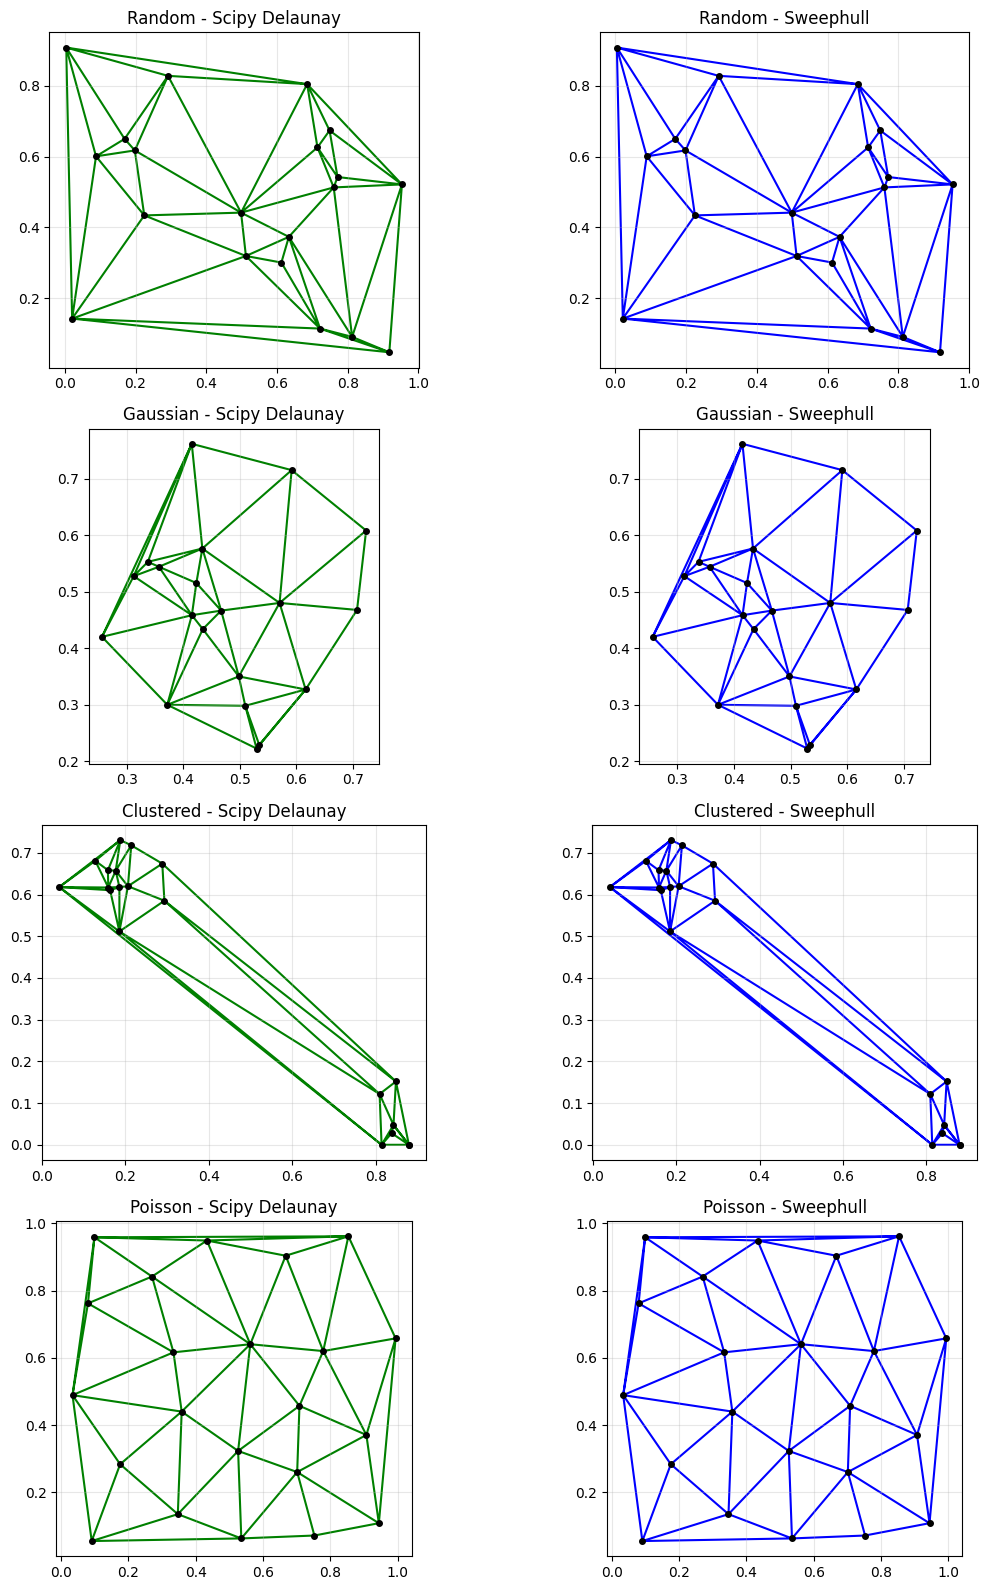

In [10]:
# Verification Step
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

# 1. Generate Data
n_verify = 20
points_verify = generate_random_points(n_points=n_verify, seed=10)
np.random.shuffle(points_verify.tolist())

points_verify_gauss = generate_gaussian_points(n_points=n_verify, seed=42)
np.random.shuffle(points_verify_gauss)

points_verify_clustered = generate_clustered_points(n_points=n_verify, seed=52)
np.random.shuffle(points_verify_clustered)

r = np.sqrt(0.625 / n_verify) 
points_verify_poisson = generate_poisson_disc_points(radius=r, seed=62)
np.random.shuffle(points_verify_poisson)

# 2. Run Flip Algorithm
custom_triangles = triangulate_sh(points_verify.tolist())
custom_triangles_gauss = triangulate_sh(points_verify_gauss.tolist())
custom_triangles_clustered = triangulate_sh(points_verify_clustered.tolist())
custom_triangles_poisson = triangulate_sh(points_verify_poisson.tolist())
# 3. Run Scipy Delaunay
delaunay = Delaunay(points_verify)
delaunay_gauss = Delaunay(points_verify_gauss)
delaunay_clustered = Delaunay(points_verify_clustered)
delaunay_poisson = Delaunay(points_verify_poisson)

scipy_simplices = delaunay.simplices
scipy_simplices_gauss = delaunay_gauss.simplices
scipy_simplices_clustered = delaunay_clustered.simplices
scipy_simplices_poisson = delaunay_poisson.simplices

# 4. Compare Results for all datasets
datasets = [
    ("Random", custom_triangles, scipy_simplices, points_verify),
    ("Gaussian", custom_triangles_gauss, scipy_simplices_gauss, points_verify_gauss),
    ("Clustered", custom_triangles_clustered, scipy_simplices_clustered, points_verify_clustered),
    ("Poisson", custom_triangles_poisson, scipy_simplices_poisson, points_verify_poisson)
]

print(f"Verification with {n_verify} points for each dataset:\n")
for name, custom, scipy, _ in datasets:
    custom_set = set(tuple(sorted(t)) for t in custom)
    scipy_set = set(tuple(sorted(t)) for t in scipy)
    is_correct = (custom_set == scipy_set)
    
    print(f"{name:12} - RIC: {len(custom_set):3d} triangles, Scipy: {len(scipy_set):3d} triangles, Match: {is_correct}")
    
    if not is_correct:
        print(f"  → In RIC only: {custom_set - scipy_set}")
        print(f"  → In Scipy only: {scipy_set - custom_set}")

# 5. Visualize All Datasets in a Grid
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for idx, (name, custom, scipy, points) in enumerate(datasets):
    # Scipy Plot (left column)
    axes[idx, 0].set_title(f"{name} - Scipy Delaunay")
    if len(scipy) > 0:
        axes[idx, 0].triplot(points[:, 0], points[:, 1], scipy, color='green')
    axes[idx, 0].plot(points[:, 0], points[:, 1], 'ko', markersize=4)
    axes[idx, 0].set_aspect('equal')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # RIC Plot (right column)
    axes[idx, 1].set_title(f"{name} - Sweephull")
    if custom:
        axes[idx, 1].triplot(points[:, 0], points[:, 1], [list(t) for t in custom], color='blue')
    axes[idx, 1].plot(points[:, 0], points[:, 1], 'ko', markersize=4)
    axes[idx, 1].set_aspect('equal')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Dataset Testing

Running for n=1000...
Running for n=1500...
Running for n=2000...
Running for n=2500...
Running for n=3000...
Running for n=3500...
Running for n=4000...
Running for n=4500...
Running for n=5000...
Running for n=5500...
Running for n=6000...
Running for n=6500...
Running for n=7000...
Running for n=7500...
Running for n=8000...
Running for n=8500...
Running for n=9000...
Running for n=9500...


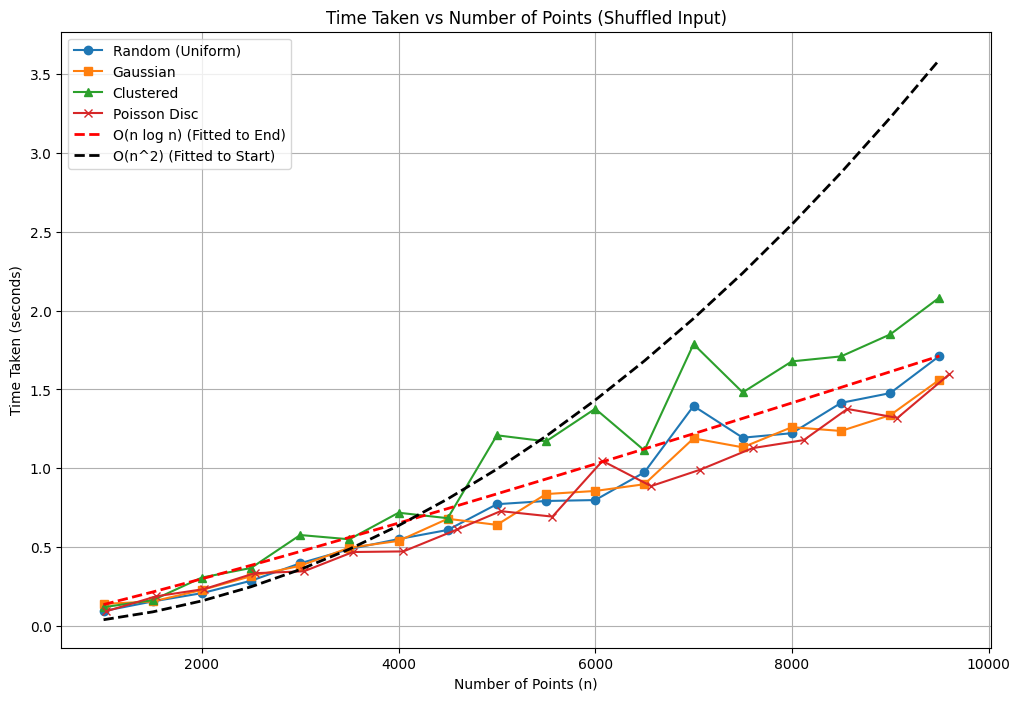

In [11]:
import time
import matplotlib.pyplot as plt
import numpy as np

ns = [i for i in range(1000, 10000, 500)]

results = {
    "Random": [],
    "Gaussian": [],
    "Clustered": [],
    "Poisson": []
}

for n in ns:
    print(f"Running for n={n}...")
    
    # Random
    pts = generate_random_points(n_points=n, seed=10)
    np.random.shuffle(pts)
    start_time = time.time()
    triangulate_sh(pts.tolist())
    end_time = time.time()
    results["Random"].append(end_time - start_time)
    
    # Gaussian
    pts = generate_gaussian_points(n_points=n, seed=42)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_sh(pts.tolist())
    end_time = time.time()
    results["Gaussian"].append(end_time - start_time)
    
    # Clustered
    pts = generate_clustered_points(n_points=n, seed=52)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_sh(pts.tolist())
    end_time = time.time()
    results["Clustered"].append(end_time - start_time)
    
    # Poisson
    r = np.sqrt(0.625 / n) 
    pts = generate_poisson_disc_points(radius=r, seed=62)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_sh(pts.tolist())
    end_time = time.time()
    results["Poisson"].append((len(pts), end_time - start_time))

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(ns, results["Random"], label="Random (Uniform)", marker='o')
plt.plot(ns, results["Gaussian"], label="Gaussian", marker='s')
plt.plot(ns, results["Clustered"], label="Clustered", marker='^')

# Poisson scatter/line
p_ns = [x[0] for x in results["Poisson"]]
p_times = [x[1] for x in results["Poisson"]]

# Sort by n (just in case)
p_sorted = sorted(zip(p_ns, p_times))
p_ns = [x[0] for x in p_sorted]
p_times = [x[1] for x in p_sorted]

plt.plot(p_ns, p_times, label="Poisson Disc", marker='x')

# Theoretical Lines
ns_arr = np.array(ns)

# Use the maximum time from Random as a reference for scaling
# We use the last point to anchor the theoretical curves
if results["Random"]:
    # 1. Fit O(n log n) to the LAST point (Max N)
    # This checks: "Does my data follow this shape?"
    ref_n_last = ns[-1]
    ref_time_last = results["Random"][-1]
    
    k_log = ref_time_last / (ref_n_last * np.log(ref_n_last))
    plt.plot(ns, k_log * (ns_arr * np.log(ns_arr)), 'r--', label="O(n log n) (Fitted to End)", linewidth=2)

    # 2. Fit O(n^2) to an EARLY point (e.g., the 5th point)
    # This checks: "If this were quadratic, where would it be by now?"
    # We skip index 0-4 to avoid initial startup noise/caching jitter
    ref_idx = 5 
    if len(ns) > ref_idx:
        ref_n_early = ns[ref_idx]
        ref_time_early = results["Random"][ref_idx]
        k2 = ref_time_early / (ref_n_early**2)
        plt.plot(ns, k2 * (ns_arr**2), 'k--', label="O(n^2) (Fitted to Start)", linewidth=2)

plt.xlabel("Number of Points (n)")
plt.ylabel("Time Taken (seconds)")
plt.title("Time Taken vs Number of Points (Shuffled Input)")
plt.legend()
plt.grid(True)
plt.show()